In [117]:
import csv
import numpy as np
import math
from operator import sub
import operator
import matplotlib.pyplot as plt

In [95]:
csv_path = "card.csv"
with open(csv_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    data = np.array(data).astype(float)
data = data[:200]
N = len(data)
l = len(data[0]) - 1
classCount = 10



In [96]:
#NORMALIZATION

maxs = [e for e in data[0]]
mins = [e for e in data[0]]
for row in data:
    for i in range(0, l):
        if row[i] > maxs[i]:
            maxs[i] = row[i]
        if row[i] < mins[i]:
            mins[i] = row[i]

normData = np.zeros((N, l + 1))
#print(normData[:5])
for i in range(0, N):
    for j in range(0, l):
        normData[i][j] = (data[i][j] - mins[j]) / (maxs[j] - mins[j])
        #print(normData[i][j])
    normData[i][l] = data[i][l]
    
#print(normData[:5])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


запоминать нормализацию

In [97]:
#DISTANCE
def euclidean(x, y):
    res = 0.0
    for a, b in zip(x, y):
        res = res + (a - b) ** 2
    return math.sqrt(res)
 
    
def chebyshev(x, y):
        return abs(max(map(sub, x, y), key=abs))


def manhattan(x, y):
        return sum(map(abs, map(sub, x, y)))
    
distance_dict = {
    "euclidean" : euclidean,
    "chebyshev" : chebyshev,
    "manhattan" : manhattan
}

#KERNEL
def uniform(x):
    if abs(x) >= 1:
        return 0
    else:
        return 0.5
 
 
def triangular(x):
    if abs(x) >= 1:
        return 0
    else:
        return 1 - abs(x)
 
 
def epanechnikov(x):
    if abs(x) >= 1:
        return 0
    else:
        return 0.75 * (1 - x ** 2)
 
 
def quartic(x):
    if abs(x) >= 1:
        return 0
    else:
        return 15 / 16 * (1 - x ** 2) ** 2
 
 
def triweight(x):
    if abs(x) >= 1:
        return 0
    else:
        return 35 / 32 * (1 - x ** 2) ** 3
 
 
def tricube(x):
    if abs(x) >= 1:
        return 0
    else:
        return 70 / 81 * (1 - abs(x) ** 3) ** 3
 
 
def gaussian(x):
    return 1 / math.sqrt(math.pi * 2) * math.exp((-0.5) * x ** 2)
 
def cosine(x):
    if abs(x) >= 1:
        return 0
    else:
        return math.pi / 4 * math.cos(math.pi / 2 * x)
 
 
def logistic(x):
    return 1 / (math.e ** x + 2 + math.e ** (-x))

def sigmoid(x):
    return 2 / math.pi / (math.e ** x + math.e ** (-x))

kernel_dict = {
    "uniform" : uniform,
    "triangular" : triangular,
    "epanechnikov" : epanechnikov,
    "quartic" : quartic,
    "triweight" : triweight,
    "tricube" : tricube,
    "gaussian" : gaussian,
    "cosine" : cosine,
    "logistic" : logistic,
    "sigmoid" : sigmoid
}

#WINDOW
def fixed(h, points, kernel):
    return list(map(lambda x: kernel(x / h), points))
 
def variable(k, points, kernel):
    h = points[k]
    return list(map(lambda x: kernel(x / h), points))


In [98]:
def calcFMeasure(v):
    n = len(v)
    summ = sum([sum(row) for row in v])
    precision_macro = 0
    recall_macro = 0
  
    for i in range(0, n):
        x = 0
        y = 0
        for j in range(0, n):
            x += v[i][j]
            y += v[j][i]
      
        precision = v[i][i] / x if x != 0 else 0
        recall = v[i][i] / y if y != 0 else 0
        precision_macro += precision * x
        recall_macro += recall * x
  
    return 2.0 * precision_macro * recall_macro / (precision_macro + recall_macro) / summ if precision_macro + recall_macro != 0 and sum != 0 else 0

In [99]:
calcFMeasure([[3, 1, 1], [3, 1, 1], [1 ,3, 1]])

0.3268608414239482

In [111]:
def subF(dist, kernel, window, hk, data, y):
    res = 0
    for i in range(1, N - 1):
        ifMatch = (1 if data[i][-1] == y else 0)
        d = distance_dict[dist](data[0][:-1], data[i][:-1])
        denom = hk if window == "fixed" else distance_dict[dist](data[0][:-1], data[hk + 1][:-1])
        res += ifMatch * kernel_dict[kernel](d / denom)
    return res

In [112]:
def getClass(dist, kernel, window, hk, row, normData):
    point = [e for e in normData[row]]
    sortedData = sorted(normData, key=lambda r: distance_dict[dist](r[:-1], point[:-1]))[1:]
    sum_dict = {clazz : subF(dist, kernel, window, hk, sortedData, clazz) for clazz in range(1, 11)}
    return max(sum_dict.items(), key=operator.itemgetter(1))[0]

In [113]:
def runCombo(dist, kernel, window, hk, normData):
    unacc = np.zeros((classCount, classCount))
    for i in range(0, N):
        prediction = getClass(dist, kernel, window, hk, i, normData)
        actual = int(normData[i][-1])
        unacc[prediction - 1][actual - 1] += 1
        #print(i, prediction, actual)
    return unacc

In [103]:
f_dict = {}
dist = "chebyshev"
for kernel in kernel_dict:
    '''
        for i in range(10, 250, 20):
        print("run calculation: " + dist, kernel, "fixed", (i+1) / 100)
        fm = calcFMeasure(runCombo(dist, kernel, "fixed", (i+1) / 100, normData))
        print("f = ", fm)
        f_dict[fm] = (dist, kernel, "fixed", (i+1) / 100)
        file.write("This is line %d\r\n" % (i+1))
    '''
    for i in range(3, 15):
        print("run calculation: " + dist, kernel, "var", i)
        fm = calcFMeasure(runCombo(dist, kernel, "var", i, normData))
        print("f = ", fm)
        f_dict[fm] = (dist, kernel, "var", i)
print(f_dict)
            

run calculation: chebyshev uniform var 3


KeyboardInterrupt: 

In [114]:
calcFMeasure((runCombo("chebyshev", "tricube", "var", 5, normData)))

0.9805346979621073

In [120]:
final_f = []
for i in range(0, 19):
    fm = calcFMeasure((runCombo("chebyshev", "uniform", "var", i, normData)))
    print(i, fm)
    final_f += (i, fm)
print(final_f)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


0 0.6601884039323894
1 0.8525527196994203
2 0.8660791985145658
3 0.9385661678710437
4 0.9659181088012552
5 0.9805346979621073
6 0.980438324098959
7 0.9901517758282941
8 0.9901723837715479
9 0.9901723837715479
10 0.9663035661792989
11 0.9853877783124096
12 1.0
13 0.9901723837715479
14 0.980689170182841
15 0.9901723837715479
16 0.9901723837715479
17 0.9901723837715479
18 0.9950431015811134
[0, 0.6601884039323894, 1, 0.8525527196994203, 2, 0.8660791985145658, 3, 0.9385661678710437, 4, 0.9659181088012552, 5, 0.9805346979621073, 6, 0.980438324098959, 7, 0.9901517758282941, 8, 0.9901723837715479, 9, 0.9901723837715479, 10, 0.9663035661792989, 11, 0.9853877783124096, 12, 1.0, 13, 0.9901723837715479, 14, 0.980689170182841, 15, 0.9901723837715479, 16, 0.9901723837715479, 17, 0.9901723837715479, 18, 0.9950431015811134]


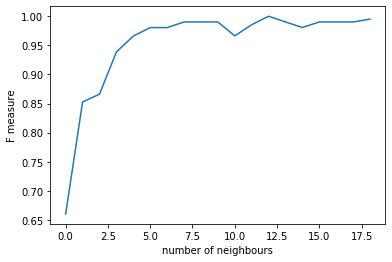

In [121]:
xs = [final_f[i] for i in range(0, len(final_f), 2)]
ys = [final_f[i] for i in range(1, len(final_f), 2)]
plt.plot(xs, ys)
plt.ylabel('F measure')
plt.xlabel('number of neighbours')
plt.show()